In [1]:
import pytz
from datetime import datetime
import matplotlib.pyplot as plt  # для вывода графиков

from tqdm import tqdm
import talib

import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
from collections import OrderedDict

from zipline.utils.calendars import get_calendar
from zipline.finance.trading import SimulationParameters
from zipline.algorithm import TradingAlgorithm
from zipline.api import order, symbol, record, order_target, order_target_percent, history, set_benchmark


In [2]:
from utils.load_local import load
#from utils.load_data_google import load

# Date range
start = datetime(1990, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2017, 7, 6, 0, 0, 0, 0, pytz.utc)

symbols = ['SPY', 'QQQ', 'IWM']
panel = load(symbols, start, end)

panel

create Db class...
connect to go_finance...
adjusted


<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 6154 (major_axis) x 5 (minor_axis)
Items axis: IWM to SPY
Major_axis axis: 1993-01-29 00:00:00+00:00 to 2017-07-06 00:00:00+00:00
Minor_axis axis: close to volume

In [3]:
def rle(inarray):
    """
    Run length encoding. Partial credit to R rle function. 
    Multi datatype arrays catered for including non Numpy
    
    Wiki: http://bit.ly/wiki_rle
    Source: htts://stackoverflow.com
    
    returns: 
        tuple (runlengths, startpositions, values) 
    """
    ia = np.array(inarray)                  # force numpy
    n = len(ia)
    if n == 0: 
        return (None, None, None)
    else:
        y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)   # must include last element posi
        z = np.diff(np.append(-1, i))       # run lengths
        p = np.cumsum(np.append(0, z))[:-1] # positions
        return(z, p, ia[i])
    

def probability(y, thresholds=(30, 70), what='top'):
    """
    Calculate reverse probability
    """
    if what == 'top':
        runlengths, startindices, values = rle(y >= thresholds[1])
        if runlengths is None:
            return 0
        above = runlengths[values]
        return len(above) / sum(above) * 100 if len(above) else 0
    elif what == 'bottom':
        runlengths, startindices, values = rle(y <= thresholds[0])
        if runlengths is None:
            return 0
        below = runlengths[values]
        return len(below) / sum(below) * 100 if len(below) else 0
    else:
        return 0

100%|██████████| 4928/4928 [00:26<00:00, 182.89it/s]


Returns: 143.02% MaxDrawdown: -11.42% Benchmark: 189.69%


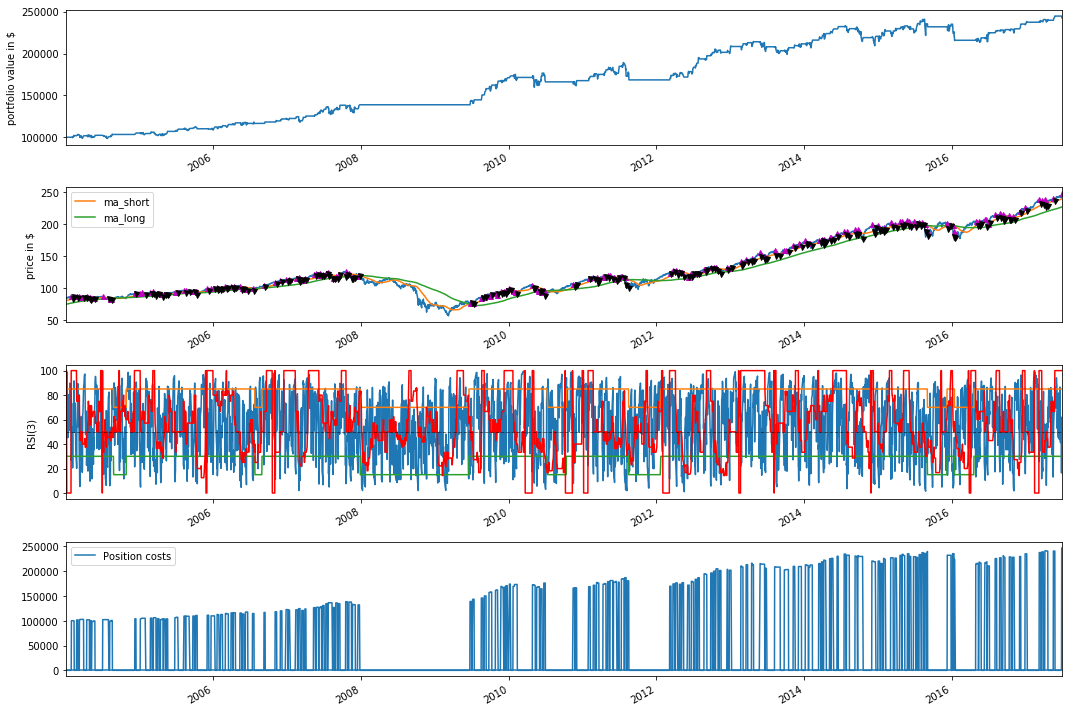

In [4]:
class RSIReversion(TradingAlgorithm):
    def initialize(context):
        context.set_benchmark(context.symbol('SPY'))
        context.asset = context.symbol('SPY')
        
        #"""
        # Returns: 12.71% MaxDrawdown: -8.01% Benchmark: 13.40% Args:  (3, 30, 70, 15,  5, 10, 20) with xSMA
        # Returns: 27.63% MaxDrawdown: -11.16% Benchmark: 13.40% Args: (3, 30, 70, 15, 11, 30, 25)
        # without xSMA
        context.RSI_PERIOD = 3
        context.RSI_BOTTOM, context.RSI_TOP, context.RSI_SHIFT = 30, 70, 15
        context.MAX_LONG, context.MAX_SHORT = 5, 15
        context.PROB_WINDOW = 10
        context.MIN_PROB = 20.
        # """
        context.MA_SHORT, context.MA_LONG = 50, 200
        
        context.days_ago = 0
        
        # add progressbar
        context.total_days = (context.sim_params.end_session - context.sim_params.start_session).days
        context.pbar = tqdm(total=context.total_days)
        #context.pbar = None

    def handle_data(context, data):        
        if not data.can_trade(context.asset):
            print("Can't trade {0}".format(context.asset.symbol))
            return
        
        prices = data.history([context.asset], 'price', 500, '1d')
        ma_short = talib.SMA(prices[context.asset].values, timeperiod=context.MA_SHORT)
        ma_long = talib.SMA(prices[context.asset].values, timeperiod=context.MA_LONG)
        rsi = talib.RSI(prices[context.asset].values, timeperiod=context.RSI_PERIOD)

        is_bear_market = ma_short[-1] < ma_long[-1]
        is_bull_market = not is_bear_market
        
        # shift thresholds
        rsi_top = context.RSI_TOP + (context.RSI_SHIFT if is_bull_market else 0)
        rsi_bottom = context.RSI_BOTTOM - (context.RSI_SHIFT if is_bear_market else 0)
        
        window = context.RSI_PERIOD * context.PROB_WINDOW
        probability_bottom = probability(
            rsi[-window:], thresholds=(context.RSI_BOTTOM, context.RSI_TOP), what='bottom')
        
        #is_bull_market = True
        #probability_bottom = 50
        
        # Trading logic # is_bull_market and probability_bottom >= context.MIN_PROB
        if is_bull_market and probability_bottom >= context.MIN_PROB:
            if rsi[-2] > rsi_bottom and rsi[-1] < rsi_bottom:
                # buy
                order_target_percent(context.asset, 1.)
                context.days_ago = 0
                #print(context.get_datetime(), 'buy', data.current(context.asset, 'price'), rsi[-1], rsi_bottom)
            elif rsi[-2] < rsi_top and rsi[-1] > rsi_top:
                order_target_percent(context.asset, 0)
        elif is_bear_market:
            order_target_percent(context.asset, 0)
        
        open_total = np.sum([x.amount * x.cost_basis for x in context.portfolio.positions.values()])
        if open_total:
            context.days_ago += 1
        
        if context.days_ago > context.MAX_LONG and not context.get_open_orders():
            order_target_percent(context.asset, 0)
            context.days_ago = 0
        
        # Save values for later inspection
        record(price=data.current(context.asset, 'price'),
               ma_short=ma_short[-1],
               ma_long=ma_long[-1],
               rsi=rsi[-1],
               rsi_top=rsi_top, 
               rsi_bottom=rsi_bottom,
               open_total=open_total,
               probability_bottom=probability_bottom
              )
        
        if context.pbar:
            # update progressbar
            days = (context.get_datetime() - context.sim_params.start_session).days
            if days > context.pbar.n:
                context.pbar.update(days - context.pbar.n)
                
    def analyze(context, perf):
        if context.pbar:
            # close progressbar, if use
            context.pbar.close()
            
        # Results
        print("Returns: {0:.2f}% MaxDrawdown: {1:.2f}% Benchmark: {2:.2f}%".format(
            perf.algorithm_period_return[-1] * 100, 
            perf.max_drawdown[-1] * 100,
            perf.benchmark_period_return[-1] * 100
        ))
            
        fig = plt.figure(figsize=(15, 10), facecolor='white')

        ax1 = fig.add_subplot(411)
        perf.portfolio_value.plot(ax=ax1)
        ax1.set_ylabel('portfolio value in $')

        ax2 = fig.add_subplot(412)
        perf['price'].plot(ax=ax2)
        perf[['ma_short', 'ma_long']].plot(ax=ax2)
        
        perf_trans = perf.ix[[t != [] for t in perf.transactions]]
        buys = perf_trans.ix[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
        sells = perf_trans.ix[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
        ax2.plot(buys.index, perf.price.ix[buys.index] * 1.02,
                 '^', markersize=5, color='m')
        ax2.plot(sells.index, perf.price.ix[sells.index] * 0.98,
                 'v', markersize=5, color='k')
        ax2.set_ylabel('price in $')
                
        ax3 = fig.add_subplot(413)
        perf['rsi'].plot(ax=ax3)
        perf['rsi_top'].plot(ax=ax3)
        perf['rsi_bottom'].plot(ax=ax3)
        perf['probability_bottom'].plot(ax=ax3, color='r')
        ax3.axhline(50, ls='-.', lw=0.5, color='k')
        """
        ax3.plot(buys.index, perf.rsi.ix[buys.index],
                 '^', markersize=6, color='m')
        ax3.plot(sells.index, perf.rsi.ix[sells.index],
                 'v', markersize=6, color='k')
        #"""
        ax3.set_ylabel('RSI(3)')
        
        ax4 = fig.add_subplot(414)
        perf['open_total'].plot(ax=ax4, label='Position costs')
        ax4.axhline(0)
        
        plt.legend(loc=0)
        plt.tight_layout()
        plt.show()

    
"""
Prepare simulation
"""
sim_params = SimulationParameters(
    start_session=pd.Timestamp('2004-01-01', tz=pytz.utc),
    end_session=pd.Timestamp('2017-07-01', tz=pytz.utc),
    capital_base=1.0e5,
    data_frequency='daily', 
    trading_calendar=get_calendar("NYSE"),
)
    
# Create algorithm object passing in initialize and
# handle_data functions
algo_obj = RSIReversion(sim_params=sim_params)

# Run algorithm
perf = algo_obj.run(panel, overwrite_sim_params=False)

In [5]:
transactions = pd.DataFrame([t for t in perf.open_total], index=perf.index).fillna(0)
transactions.tail()

,0
2017-06-26 20:00:00+00:00,0.000000
2017-06-27 20:00:00+00:00,0.000000
2017-06-28 20:00:00+00:00,246906.465005
2017-06-29 20:00:00+00:00,246906.465005
2017-06-30 20:00:00+00:00,246906.465005


In [6]:
def rle(inarray):
    """
    Run length encoding. Partial credit to R rle function. 
    Multi datatype arrays catered for including non Numpy
    
    Wiki: http://bit.ly/wiki_rle
    Source: htts://stackoverflow.com
    
    returns: 
        tuple (runlengths, startpositions, values) 
    """
    ia = np.array(inarray)                  # force numpy
    n = len(ia)
    if n == 0: 
        return (None, None, None)
    else:
        y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)   # must include last element posi
        z = np.diff(np.append(-1, i))       # run lengths
        p = np.cumsum(np.append(0, z))[:-1] # positions
        return(z, p, ia[i])

# prepare overlays
overlays_rect = []
overlays = []
    
signals = np.sign(perf['open_total'])
runlengths, startindices, values = rle(signals)

for i, v in enumerate(values):
    idx = startindices[i]
    params = {}
    if v > 0:
        overlays.append(('vline', (signals.index[idx].date(),), 'green', {'lw': 0.75}))
        overlays.append(('rect', (signals.index[idx].date(), runlengths[i]), 'green', params))
    elif v < 0:
        overlays.append(('vline', (signals.index[idx].date(),), 'red', {'lw': 0.75}))
        overlays.append(('rect', (signals.index[idx].date(), runlengths[i]), 'red', params))
        
overlays[-5:]

[('rect', (datetime.date(2017, 4, 6), 10), 'green', {}),
 ('vline', (datetime.date(2017, 5, 18),), 'green', {'lw': 0.75}),
 ('rect', (datetime.date(2017, 5, 18), 6), 'green', {}),
 ('vline', (datetime.date(2017, 6, 28),), 'green', {'lw': 0.75}),
 ('rect', (datetime.date(2017, 6, 28), 3), 'green', {})]

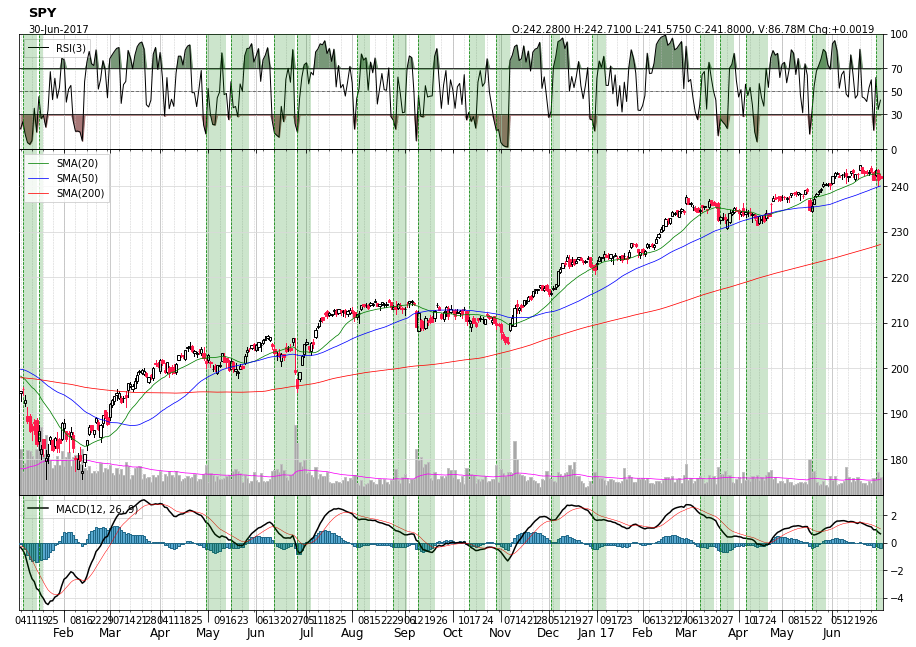

In [9]:
from datetime import date
from finchart import FinanceChart

begin = date(2016, 1, 1)
end = date(2017, 7, 1)

chart = FinanceChart(begin=begin, end=end, colors={'sma':{'sma20': 'green', 'sma50': 'blue'}}, size=(1, 1))
behind_price = [
    ('sma', 20),
    ('sma', 50),
    ('sma', 200),
    ('volume', 'ema', 39),
]
top = [
    ('rsi', 3),
    #('mfi', 5),
]
bottom = [
    ('macd', 12, 26, 9),    
]

df = panel['SPY'].copy()
df['symbol'] = 'SPY'
df['dt'] = df.index
chart.chart(df, behind_price=behind_price, top=top, bottom=bottom, overlays=overlays).show()